# 1D Darcy Flow (Groundwater) Solution and Benchmark

In [1]:
import underworld as uw
import glucifer
import numpy
import matplotlib.pyplot as plt

uw.matplotlib_inline()

This notebook demonstrates the use of the ``uw.systems.SteadyStateDarcyFlow`` class, which solves for darcy flow (e.g. groundwater flow):

$\nabla q = 0$

$q = \kappa \left( -\nabla p + S \right)$ 

where $q$ is the flow velocity, $p$ is the fluid pressure head, $\kappa$ hydraulic diffusivity and $S$ is a hydraulic gradient source. $S$ is usually a gravitational term, for example $S = \rho g$, where $\rho$ is fluid density and $g$ is the  gravitational accelleration vector.

We will set up a simple example of flow through two  of strongly contrasting $\kappa$ and compare the soultion to a 1D benchmark.

*Set up mesh and fields*

**Note:** The velocity solution is extremely sensitive to the pressure gradient. A higher order shape function (Q2) may result in a more accurate solution of the pressure field, in the case of material variation within a cell, but the velocity would then be linearly variable within that cell. It is therefore best to use a linear shape function (Q1) and asign just one material per cell.

In [2]:
elementType = "Q1"
resX = 16
resY = 16
mesh = uw.mesh.FeMesh_Cartesian( elementType = (elementType), 
                                 elementRes  = (resX, resY), 
                                 minCoord    = (-1., -1.), 
                                 maxCoord    = (0., 0.)) 

gwPressureField    = mesh.add_variable( nodeDofCount=1 )
hydraulicDiffusivityField    = mesh.add_variable( nodeDofCount=1 )
velocityField = mesh.add_variable(nodeDofCount=2)

*Set up the types of boundary conditions*

**Note:** The darcy-flow solver does also work for a lower free-slip boundary condition, but only if a strong horizontal flow component exists, such as arises when there is topographic variation. 

In [3]:
iWalls     = mesh.specialSets["MinI_VertexSet"] + mesh.specialSets["MaxI_VertexSet"]
jWalls     = mesh.specialSets["MinJ_VertexSet"] + mesh.specialSets["MaxJ_VertexSet"]
topWall    = mesh.specialSets["MaxJ_VertexSet"]
bottomWall = mesh.specialSets["MinJ_VertexSet"]

gwPressureBC = uw.conditions.DirichletCondition( variable        = gwPressureField, 
                                               indexSetsPerDof = ( topWall+ bottomWall    ) )

*Choose the pressure set at the lower wall and set an initially linear pressure field which is consistent with the BCs*

In [4]:
#Groundwater pressure boundary condition on the bottom wall
#    this value is relative to gravity
maxgwpressure = 0.5

yCoordFn  = uw.function.input()[1]
initialFn = -1. * yCoordFn * maxgwpressure

gwPressureField.data[:] = initialFn.evaluate(mesh)

*Set up swarm*

**Imporant Note:** The swarm is used for setting the $\kappa$ for a cell. As a result of our choice of a linear shape-function (Q1), there is a single constant pressure gradient solved for each cell. If we were to use particles with strongly contrasting $\kappa$ in one cell, the actual solution should involve a strong variation in pressure gradient which cannot be reproduced by the constant pressure gradient solved. It is therefore recommended that only one particle is used per cell. For the same reason, velocity should be calculated inside the cell, rather than on the mesh. Our swarm is used both for setting $\kappa$ and calculating the velocity.


In [5]:
swarm         = uw.swarm.Swarm( mesh=mesh )
swarmLayout = uw.swarm.layouts.PerCellGaussLayout(swarm=swarm,gaussPointCount=1)
swarm.populate_using_layout(swarmLayout)

Set up swarm variables: material ID and velocity. The velocity variable is where the velocity solution can be stored.

In [6]:
materialIndex     = swarm.add_variable( dataType="int",    count=1 )
materialVelocity  = swarm.add_variable( dataType="double",    count=2 )

materialPorous        = 0
materialImpermeable   = 1

Set up a horizontal interface between the two materials

In [7]:
xCoordFn = uw.function.input()[0]
yCoordFn = uw.function.input()[1]

interfaceY = -0.25

conditions = [ (yCoordFn > interfaceY, materialPorous),
               ( True , materialImpermeable )]

materialfn = uw.function.branching.conditional( conditions )
materialIndex.data[:]  = materialfn.evaluate(swarm)

Assign a different $\kappa$ to each material. The upper layer in this case is much more permeable than the lower.

In [8]:
Ka = 1.
Kb = 1e-3

hydraulicDiffusivityMap = { materialPorous : Ka, 
                 materialImpermeable : Kb}
hydraulicDiffusivityMapFn = uw.function.branching.map( fn_key = materialIndex, mapping = hydraulicDiffusivityMap )

Let's check that the $\kappa$ asigned to each particle looks correct:


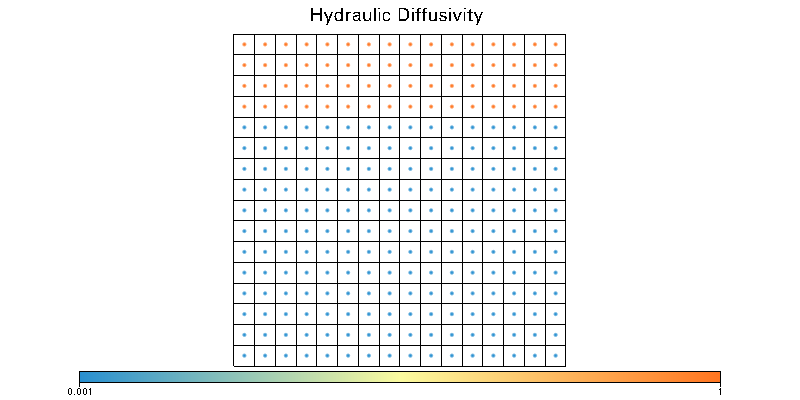

In [9]:
figMaterial = glucifer.Figure( figsize=(800,400), title="Hydraulic Diffusivity" )
figMaterial.append( glucifer.objects.Points(swarm, hydraulicDiffusivityMapFn, pointSize=5.0) )

figMaterial.append( glucifer.objects.Mesh(mesh))
figMaterial.show()

*Setup the dary flow (groundwater) equation*

In [10]:
g = uw.function.misc.constant((0.,-1.))


gwadvDiff = uw.systems.SteadyStateDarcyFlow(velocityField=velocityField,
        pressureField = gwPressureField, fn_diffusivity = hydraulicDiffusivityMapFn,
        conditions=[gwPressureBC],fn_bodyforce=g, 
        voronoi_swarm=swarm,swarmVarVelocity=materialVelocity)
gwsolver = uw.systems.Solver(gwadvDiff)

In [11]:
gwsolver.solve()

*Visualise the groundwater solution, by plotting it for $x=-1$ (left wall).*

This model is simple enough that there is an equivalent 1D analytic, which we can use as a benchmark. Out of interest, let's also plot what the solution would look like without the gravity term.

The grey lines are the horizontal element edges. Note that an resolution has been chosen so that the interface boundary is accurately resolved.

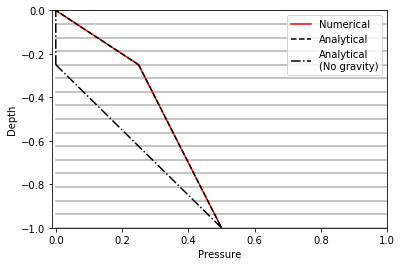

In [12]:
if uw.rank() == 0:
    arrX = numpy.linspace(-1,0,2)
    plt.ylim(-1,0.)
    plt.xlim(-1e-2,1)

arrY = numpy.linspace(-1,0.,100)
x = -1.
arrP = gwPressureField.evaluate_global(numpy.array(zip(numpy.ones(100)*x,arrY)))

if uw.rank() == 0:
    plt.plot(arrP,arrY,c='red',label='Numerical')


    for S in [1.,0.]:
        La = -1. * interfaceY
        Lb = 1. + interfaceY
        dP = maxgwpressure
        Pa = (dP/Lb - S + Ka/Kb * S) / (1./Lb + Ka/Kb/La)
        arrYl = numpy.linspace(-La,0.,3)
        if S == 0.:
            label = "Analytical\n(No gravity)"
            line = "-."
        else:
            label = 'Analytical'
            line = "--"
        plt.plot(Pa*(-arrYl)/(La),arrYl,line,c="black",label = label)
        arrYl = numpy.linspace(-La,-1,3)
        plt.plot(Pa + (dP-Pa)*(-arrYl-La)/Lb,arrYl,line,c="black")
    
if uw.rank() == 0:
    plt.xlabel('Pressure')
    plt.ylabel('Depth')
    plt.legend()
    
    for meshY in numpy.linspace(-1,0,resY+1):
        plt.plot(numpy.linspace(0,1,2),numpy.ones(2)*meshY,c="black",alpha=0.3)

    
    plt.savefig('PressureSolution.pdf')

The velocity solution was found on the swarm, so let's visualise the swarm variable where it is kept. The vertical component of the velocity vector field is visualised. Note the colourbar - the solution is relatively constant, as it should be for flow conservation.


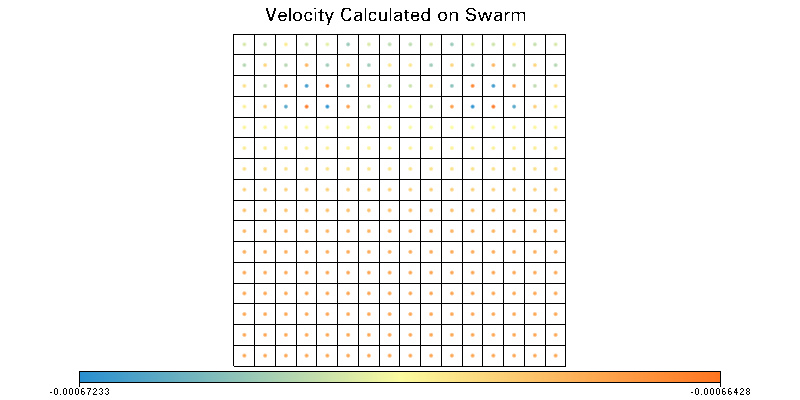

In [13]:
figMaterial = glucifer.Figure( figsize=(800,400), title="Velocity Calculated on Swarm" )
figMaterial.append( glucifer.objects.Points(swarm, materialVelocity[1], pointSize=5.0) )
figMaterial.append( glucifer.objects.Mesh(mesh))
figMaterial.show()

Plot the same velocity field as vectors, over the pressure field solution.


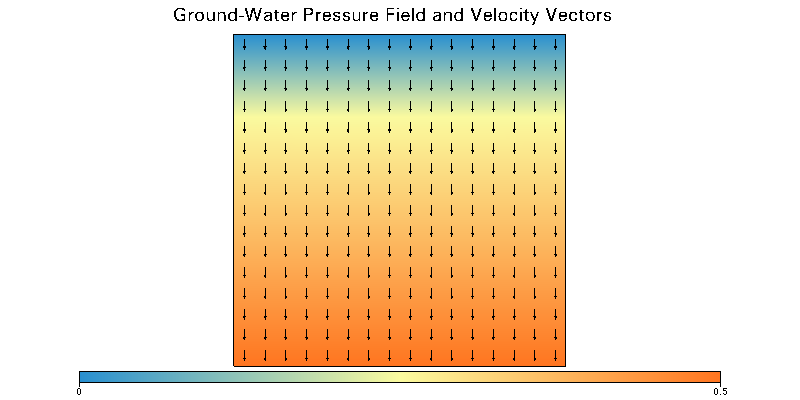

In [14]:
figMaterial = glucifer.Figure( figsize=(800,400),title="Ground-Water Pressure Field and Velocity Vectors" )
figMaterial.append(glucifer.objects.Surface(mesh,gwPressureField,onMesh=True))
scale = 0.03
figMaterial.append(glucifer.objects.VectorArrows(mesh,velocityField,scaling=50,arrowHead=0.3))
figMaterial.show()

We can also compare the velocity calculated on the swarm to an analytical solution.

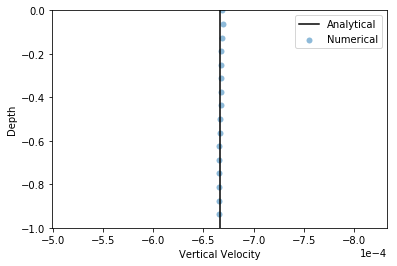

In [15]:
x = -1.
n = 30
arrYsample = numpy.linspace(-1+(1./resY),0.,resY)
arrY = numpy.linspace(-1,0.,n)

arrP = numpy.array(velocityField[1].evaluate_global(numpy.array(zip(numpy.ones(len(arrYsample))*x,arrYsample))))

if uw.rank() == 0:
    plt.clf()
    plt.scatter(arrP,arrYsample,lw=0,alpha=0.5,label="Numerical")

    S = 1.
    La = -1. * interfaceY
    Lb = 1. + interfaceY
    dP = maxgwpressure
    midPressure = (dP/Lb - S + Ka/Kb * S) / (1./Lb + Ka/Kb/La)

    arrVel = numpy.zeros(len(arrY))

    for i in range(len(arrY)):
        if arrY[i] > interfaceY:
            arrVel[i] = (-midPressure / -La - 1.) * Ka
        else:
            arrVel[i] = (-(dP - midPressure)/-Lb - 1.) * Kb

    plt.plot( (arrVel) ,arrY,c="black",label="Analytical")

    plt.ylim(-1,0.)
    avAnVel = numpy.average(arrVel)
    plt.xlim(-0.25*avAnVel + avAnVel,0.25*avAnVel+avAnVel)
    plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
    plt.legend()
    plt.xlabel('Vertical Velocity')
    plt.ylabel('Depth')

    plt.savefig("VelocitySolution.pdf")